# Run The Agent on Mountain Car

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import gym

import pandas as pd

In [2]:
from vae_recurrent import VAE, create_decoder, create_encoder
from transition_gru import TransitionGRU
from recurrent_agent import DAIFAgentRecurrent
from prior_model import PriorModelBellman
from habitual_action_network import HabitualAction, compute_discounted_cumulative_reward
from ddpg import *

In [3]:
from util import random_observation_sequence, transform_observations, test_policy, habit_policy
from train_agent import train_single_agent

In [4]:
# from identity_vae import IdentityVAE, identity_encoder, identity_decoder

What does the agent do?
- The agent plans using a policy then executes that policy for 12 simulation timesteps, the first two actions of the policy are executed for 6 steps each

What data does it accumulate?
- It accumulates 12 observation actions pairs

How is it trained?
- VAE is trained to reproduce observations using the latent states
- Transition is trained by taking previous hidden state and previous latent state and trying to predict the next latent state


Online learning For all tasks, we initialize all the agents with random weights and learn online only. Training an agent for 150 epochs takes about 3 minutes on a single CPU core (Intel I7-4870HQ). In contrast, previous approaches using active inference [Ueltzhöffer, 2018, Tschantz et al., 2019, 2020] and policy gradient methods (e.g., [Liu et al., 2017]) use (offline) policy replay and typically need hours of GPU-accelerated compute while achieving similar convergence. To our knowledge, this is the first model-based RL method to learn online using neural network representations. This is afforded by the high sample efficiency of the FEEF, which directs exploration towards states that are uncertain for both the encoder and transition models.


Why this is true?

In [5]:
# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

## Test with no prior model FEEF

In [6]:
pln_hrzn = 5
latent_dim = 2
obs_dim = 2

# make the VAE
enc = create_encoder(2, latent_dim, [20])
dec = create_decoder(latent_dim, 2, [20])
vae = VAE(enc, dec, latent_dim,  [0]*latent_dim, [0.3]*latent_dim, train_epochs=2, show_training=False)
vae.compile(optimizer=tf.keras.optimizers.Adam())

# make the TRANSITION
tran = TransitionGRU(latent_dim, 1, 2*pln_hrzn*latent_dim, 2, train_epochs=2, show_training=False)
tran.compile(optimizer=tf.keras.optimizers.Adam())

# make the HABIT ACTION NET
habit_net = HabitualAction(latent_dim, 1, [16, 16], train_epochs=2, show_training=False)
habit_net.compile(optimizer=tf.keras.optimizers.Adam())

# # # make the HABIT ACTION NET
# actor_model = get_actor(2, 1)
# critic_model = get_critic(2, 1)
# target_actor = get_actor(2, 1)
# target_critic = get_critic(2, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
# critic_optimizer = tf.keras.optimizers.Adam(0.0001)
# actor_optimizer = tf.keras.optimizers.Adam(0.00005)
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)


# make the PRIOR NET
prior_model = PriorModelBellman(latent_dim, output_dim=1, scaling_factor=0.01, show_training=False, use_tanh_on_output=False)

# unscaled prior mean and prior stddev
prior_mean = [0.45, 0]
prior_stddev = [1, 1]

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# observation_noise_stddev = [0, 0]
observation_noise_stddev = [0.05, 0.05]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0,0])  # no noise on prior

In [7]:
daifa = DAIFAgentRecurrent(prior_model,
                           vae,
                           tran,
                           habit_net,
                           planning_horizon=pln_hrzn,
                           use_kl_extrinsic=False,  # maybe this works
                           use_kl_intrinsic=True,
                           use_FEEF=False,
                           train_habit_net=True,
                           train_prior_model=True,
                           train_tran=True,
                           train_after_exploring=True,
                           train_with_replay=True,
                           use_fast_thinking=True,
                           habit_model_type="PG",
                           uncertainty_tolerance=0.1)


daifa.train_prior = True
daifa.prior_model.show_training = False

In [8]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_one = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=60, render_env=False)

Episode 1
[-0.42492077  0.        ]
fast thinking
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2022-09-25 08:54:35.650756: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


fast thinking
fast thinking
training on full data
2 85
Success in episode 1 at time step 505 with reward 94.22228858932243
Episode 2
[-0.56138307  0.        ]
fast thinking
training on full data
0 44
Success in episode 2 at time step 260 with reward 96.41521896993387
Episode 3
[-0.4461571  0.       ]
fast thinking
fast thinking
training on full data
1 167
No Success
Episode 4
[-0.46491876  0.        ]
fast thinking
fast thinking
fast thinking
training on full data
2 99
Success in episode 4 at time step 594 with reward 92.78256772778305
Episode 5
[-0.43733624  0.        ]
fast thinking
training on full data
0 45
Success in episode 5 at time step 265 with reward 97.1806794912961
Episode 6
[-0.5474657  0.       ]
fast thinking
fast thinking
fast thinking
training on full data
2 33
Success in episode 6 at time step 197 with reward 97.9738371159938
Episode 7
[-0.48186108  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast think

In [9]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.228980,342,57
1,99.412096,300,50
2,98.968392,324,54
3,99.065573,270,45
4,99.224644,270,45
5,99.229619,354,59
6,99.271033,264,44
7,99.043048,282,47
8,99.379049,270,45
9,98.903963,288,48


In [10]:
daifa.train_vae = False
daifa.model_vae.show_training = False

In [11]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_two = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, render_env=False)

Episode 1
[-0.5352973  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
10 25
Success in episode 1 at time step 147 with reward 98.83876505719894
Episode 2
[-0.44620052  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
10 27
Success in episode 2 at time step 161 with reward 98.56105571912401
Episode 3
[-0.4768014  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
13 30
Success in episode 3 at time step 180 with reward 98.36481992275584
Episode 4
[-0.5357716  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking


In [12]:
# # make the HABIT ACTION NET
# habit_net = HabitualAction(latent_dim, 1, [16, 16], train_epochs=2, show_training=True)
# habit_net.compile(optimizer=tf.keras.optimizers.Adam())
#
# daifa.habit_action_model = habit_net
#
# actor_model = get_actor(latent_dim, 1)
# critic_model = get_critic(latent_dim, 1)
#
# target_actor = get_actor(latent_dim, 1)
# target_critic = get_critic(latent_dim, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
#
# critic_optimizer = tf.keras.optimizers.Adam(0.0001)
# actor_optimizer = tf.keras.optimizers.Adam(0.00005)
#
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)

In [13]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.375816,186,31
1,99.274439,186,31
2,98.946161,276,46
3,98.855224,294,49
4,99.252322,180,30
5,99.178609,270,45
6,99.161616,318,53
7,99.139937,276,46
8,99.267220,192,32
9,99.297228,198,33


In [14]:
daifa.habit_action_model.show_training = False
daifa.train_habit_net = True
daifa.train_after_exploring = True
daifa.use_kl_intrinsic = True
daifa.use_kl_extrinsic = False
daifa.use_fast_thinking = True
daifa.uncertainty_tolerance = 0.1

# daifa.tran.show_training = False
# daifa.prior_model.show_training = False

# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_three = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, render_env=False)

Episode 1
[-0.58417547  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
11 27
Success in episode 1 at time step 157 with reward 98.53794075788218
Episode 2
[-0.4126189  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
6 16
Success in episode 2 at time step 94 with reward 99.14673067591754
Episode 3
[-0.5749199  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
15 36
Success in episode 3 at time step 212 with reward 98.01988298638156
Episode 4
[-0.5200022  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fa

In [15]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.088804,174,29
1,99.024967,252,42
2,98.970162,174,29
3,99.037108,174,29
4,99.104555,174,29
5,99.168046,174,29
6,99.029830,180,30
7,99.251702,186,31
8,99.110772,168,28
9,99.249844,180,30


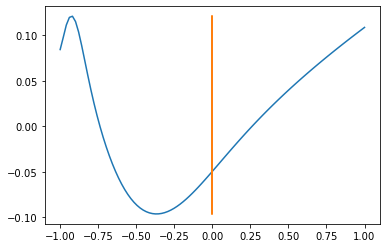

In [16]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

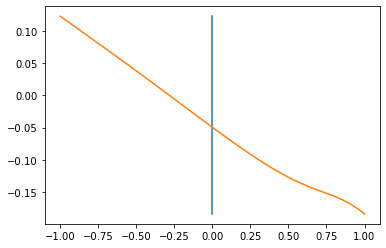

In [17]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

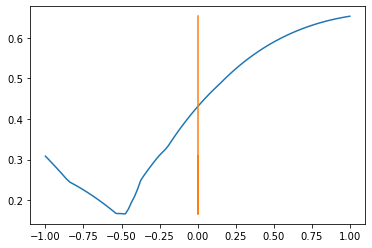

In [18]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_fast_thinking_policy(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

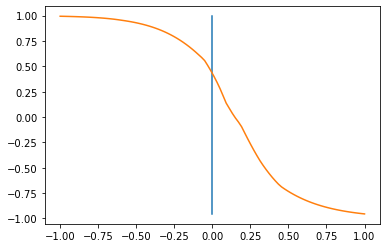

In [19]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_fast_thinking_policy(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

In [20]:
env = gym.make('MountainCarContinuous-v0')
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 5, daifa.agent_time_ratio, show_env=True)
res

,reward,timesteps,num_actions
0,99.312159,174,29
1,99.146652,174,29
2,99.276964,180,30
3,99.129453,168,28
4,99.199694,180,30


In [ ]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_four = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=50, render_env=False, flip_dynamics=False)

Episode 1
[-0.5958538  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
24 39
Success in episode 1 at time step 229 with reward 98.42801505676881
Episode 2
[-0.45815662  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
8 29
Success in episode 2 at time step 171 with reward 98.23162916257424
Episode 3
[-0.572035  0.      ]
fast thinking


In [ ]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

In [ ]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_four = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=50, render_env=False, flip_dynamics=True)

In [ ]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

In [ ]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 4, daifa.agent_time_ratio, show_env=False)
res

In [ ]:
full_results = pd.concat([results_one, results_two, results_three, results_four])
full_results.reset_index(drop=True)
full_results

In [ ]:
T = np.arange(len(full_results))
plt.plot(T, full_results.percent_use_fast_thinking)

In [ ]:
plt.plot(T, full_results.success)

In [ ]:
plt.plot(T, full_results.total_reward)

In [ ]:
plt.plot(T, full_results.sim_steps)